# Fraud detection

1. Imports
2. EDA
3. Data preprocessing/splitting
4. Model training
5. Evaluation

PaySim Dataset Description
- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction.

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [33]:
# import os
# os.environ['http_proxy'] = "http://squid.cs.ait.ac.th:3128/"
# os.environ['https_proxy'] = "http://squid.cs.ait.ac.th:3128/"

In [3]:
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116 --user
# !pip install imblearn

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     |█████████████████████████████▉  | 1843.0 MB 98.7 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 1977.9 MB 623 bytes/s          
     |████████████████████████████████| 24.2 MB 38.0 MB/s            
     |████████████████████████████████| 4.2 MB 30.4 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 258 kB 1.8 MB/s            
     |████████████████████████████████| 301 kB 30.5 MB/s            
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [92]:
# 1. Imports
import os
import collections
from collections import defaultdict
import random
import joblib

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset

import torchvision.transforms as transforms


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
VISUALIZATION_DIRECTORY = './visualizations'
MODELS_TRAINED_DIRECTORY = './models'
STATISTICS_DIRECTORY = './statistics'
DATASET_DIRECTORY = '../Datasets'
DATASET_FILE = os.path.join(DATASET_DIRECTORY, 'PaySim.csv')

os.makedirs(STATISTICS_DIRECTORY, exist_ok=True)
os.makedirs(MODELS_TRAINED_DIRECTORY, exist_ok=True)
os.makedirs(VISUALIZATION_DIRECTORY, exist_ok=True)

In [3]:
# 2. EDA
df = pd.read_csv(DATASET_FILE)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
df.shape

(6362620, 11)

In [12]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [13]:
df.duplicated().value_counts()

False    6362620
dtype: int64

In [14]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
cat_columns = df.select_dtypes(include=['object']).columns

In [15]:
def outlier_num(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

    print(f"Feature '{feature}' has {len(outliers)} outliers")

    return outliers


for feat in num_columns:
    outlier_num(df, feat)

Feature 'step' has 102688 outliers
Feature 'amount' has 338078 outliers
Feature 'oldbalanceOrg' has 1112507 outliers
Feature 'newbalanceOrig' has 1053391 outliers
Feature 'oldbalanceDest' has 786135 outliers
Feature 'newbalanceDest' has 738527 outliers
Feature 'isFraud' has 8213 outliers
Feature 'isFlaggedFraud' has 16 outliers


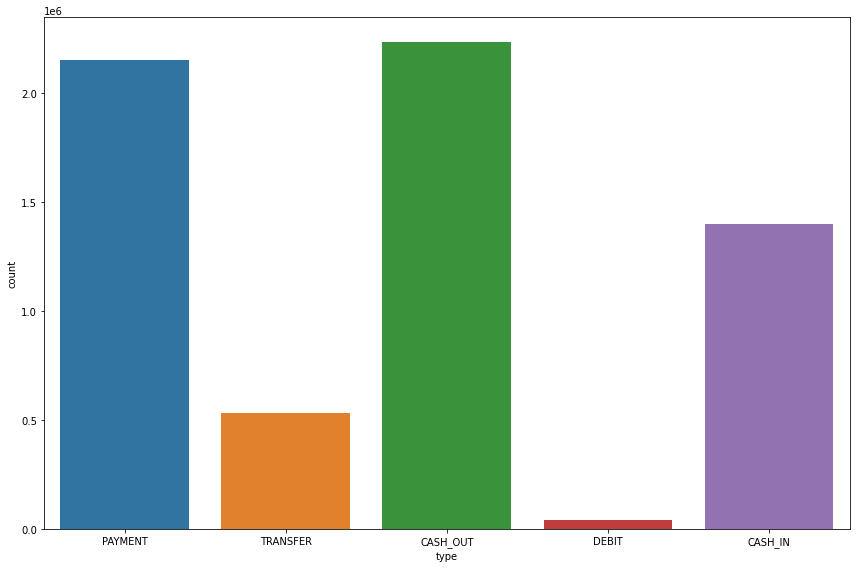

In [16]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(x='type', data=df)

plt.tight_layout()

plt.savefig(f"{VISUALIZATION_DIRECTORY}/df_type_column.png", dpi=300, bbox_inches="tight")

plt.show()

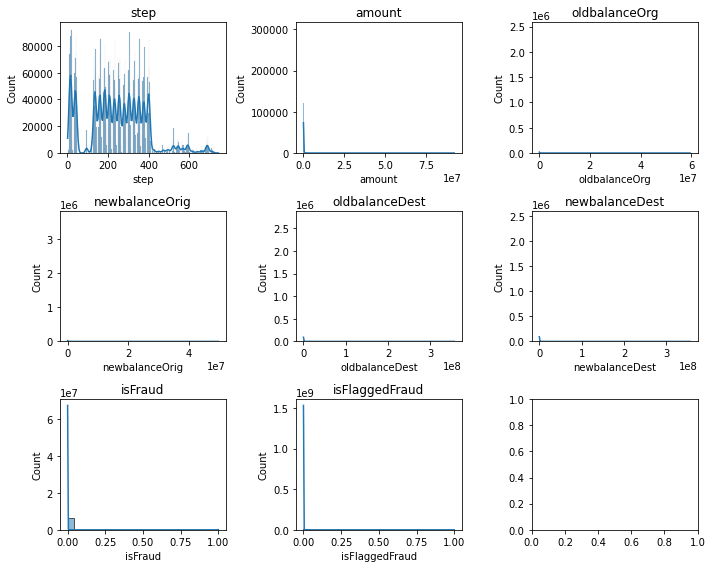

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.flatten()

for i, feature in enumerate(num_columns):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'{feature}')

plt.tight_layout()

plt.savefig(f"{VISUALIZATION_DIRECTORY}/df_num_cols_dstrb.png", dpi=300, bbox_inches="tight")

plt.show()

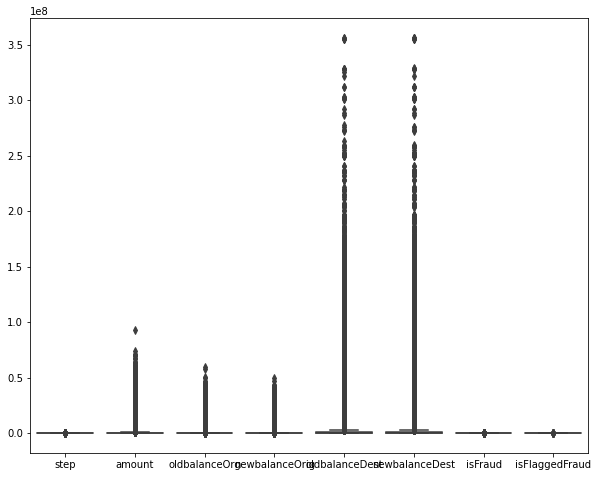

In [18]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[num_columns])

plt.savefig(f"{VISUALIZATION_DIRECTORY}/df_num_cols_bxplt.png", dpi=300, bbox_inches="tight")

plt.show()

In [19]:
paysim_pivot1=pd.pivot_table(df,index=["type"],values=['amount','isFraud','isFlaggedFraud'],aggfunc=[np.sum,np.std], margins=True)

#Adding color gradient 
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot1.style.background_gradient(cmap=cm)

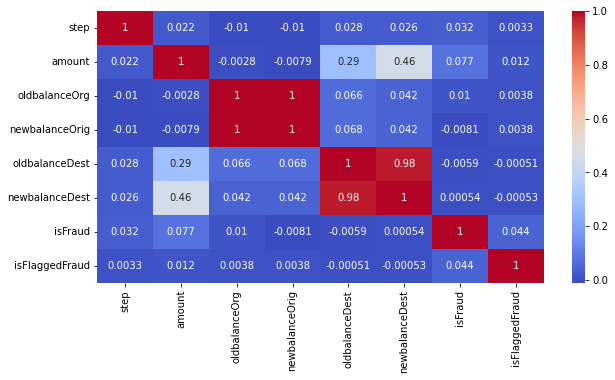

In [22]:
plt.figure(figsize = (10,5))
sns.heatmap(df[num_columns].corr(), annot=True, cmap="coolwarm")

plt.savefig(f"{VISUALIZATION_DIRECTORY}/df_cm_coolwarm.png", dpi=300, bbox_inches="tight")

plt.show()

In [4]:
X = df.drop(['step', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

num_columns = X.select_dtypes(include=['int64', 'float64']).columns
cat_columns = X.select_dtypes(include=['object']).columns

In [5]:
# Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((5090096, 6), (1272524, 6))

In [6]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

# No need for imputation - no missing values
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_columns),
    ('cat', categorical_transformer, cat_columns),
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [7]:
smote = SMOTE(random_state=42)
X_train_preprocessed_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Before smote class distribution: {collections.Counter(y_train)}\nAfter: {collections.Counter(y_train_resampled)}")

Before smote class distribution: Counter({0: 5083526, 1: 6570})
After: Counter({0: 5083526, 1: 5083526})


In [27]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_preprocessed_resampled, y_train_resampled)

y_pred = model.predict(X_test_preprocessed)

In [28]:
filename = f"{MODELS_TRAINED_DIRECTORY}/baseline_lr_model.pkl"
joblib.dump(model, filename)
print("Model saved as baseline_lr_model.pkl")

Model saved as baseline_lr_model.pkl


In [29]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.style.background_gradient(cmap='Blues')

report_df.to_csv(f"{STATISTICS_DIRECTORY}/baseline_lr_classification_report.csv", index=True)
print("Classification report saved as 'classification_report.csv'")

Classification report saved as 'classification_report.csv'


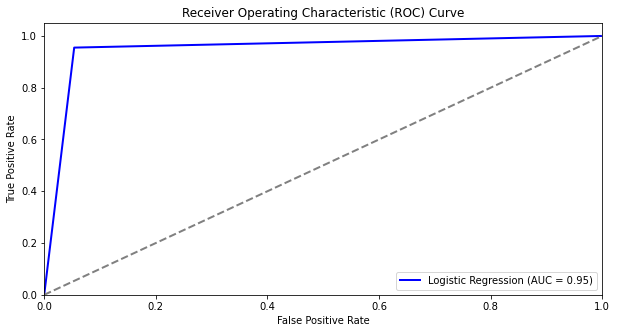

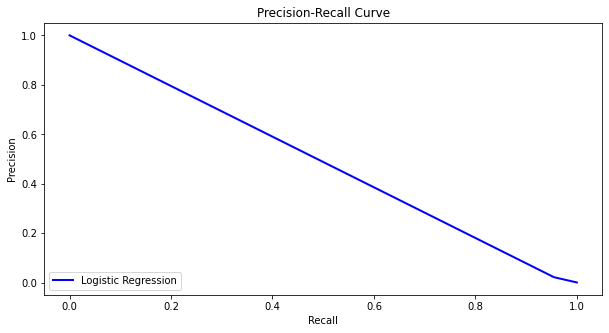

In [30]:
def plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.savefig(f"{VISUALIZATION_DIRECTORY}/{filename}.png", dpi=300, bbox_inches="tight")

    plt.show()


def plot_pr_curve(recall_lr, precision_lr, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(recall_lr, precision_lr, color='blue', lw=2, label='Logistic Regression')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.savefig(f"{VISUALIZATION_DIRECTORY}/{filename}.png", dpi=300, bbox_inches="tight")

    plt.show()

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, 'baseline_lr_roc_curve')

# Calculate Precision-Recall curve for Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred)

plot_pr_curve(recall_lr, precision_lr, 'baseline_lr_precision_recall')

Train AUC: 0.9989
Test AUC: 0.9983


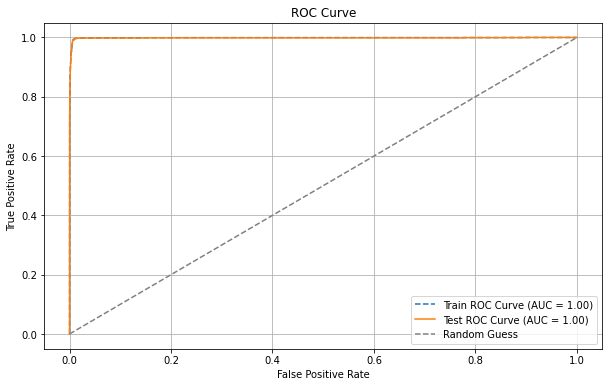

In [31]:
# Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_preprocessed_resampled, y_train_resampled)

y_train_pred_proba = gbc.predict_proba(X_train_preprocessed_resampled)[:, 1]
y_test_pred_proba = gbc.predict_proba(X_test_preprocessed)[:, 1]

train_fpr, train_tpr, _ = roc_curve(y_train_resampled, y_train_pred_proba)
train_auc = roc_auc_score(y_train_resampled, y_train_pred_proba)

test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f"Train ROC Curve (AUC = {train_auc:.2f})", linestyle="--")
plt.plot(test_fpr, test_tpr, label=f"Test ROC Curve (AUC = {test_auc:.2f})", linestyle="-")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()

plt.savefig(f"{VISUALIZATION_DIRECTORY}/gradient_boosting_roc_curve.png", dpi=300, bbox_inches="tight")

plt.show()

In [42]:
report = classification_report(y_test, np.round(y_test_pred_proba), output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.style.background_gradient(cmap='Blues')

report_df.to_csv(f"{STATISTICS_DIRECTORY}/gbc.csv", index=True)
print("Classification report saved as 'classification_report.csv'")

Classification report saved as 'classification_report.csv'


In [35]:
filename = f"{MODELS_TRAINED_DIRECTORY}/gbc.pkl"
joblib.dump(gbc, filename)
print("Model saved as baseline_lr_model.pkl")

Model saved as baseline_lr_model.pkl


In [ ]:
# Pipeline to compare all models
from sklearn.metrics import make_scorer
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def custom_scorer(estimator, X, y):
    # Log current classifier being used
    classifier = estimator.named_steps['classifier']
    logger.info(f"Evaluating model: {type(classifier).__name__}")
    logger.info(f"Parameters: {classifier.get_params()}")
    # Use a default scoring metric, like roc_auc_score
    from sklearn.metrics import roc_auc_score
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

model_pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.1, 1]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [2],
        'classifier__bootstrap': [True]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1]
    }
]

sgf=StratifiedGroupKFold(n_splits=5)

# grid_search = GridSearchCV(
#     estimator=model_pipeline,
#     param_grid=param_grid,
#     cv=sgf,
#     scoring='roc_auc',
#     verbose=2,
#     n_jobs=-1  # Use parallel processing for faster computation
# )
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=sgf,
    scoring=make_scorer(custom_scorer),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_preprocessed_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
best_model

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: custom_scorer() missing 1 required positional argument: 'y'

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent cal

In [8]:
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

best_rf.fit(X_train_preprocessed_resampled, y_train_resampled)

RandomForestClassifier(max_depth=10, random_state=42)

In [12]:
y_pred_rf = best_rf.predict(X_test_preprocessed)

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_rf_df = pd.DataFrame(report_rf).transpose()
report_rf_df.style.background_gradient(cmap='Blues')

report_rf_df.to_csv(f"{STATISTICS_DIRECTORY}/best_rf.csv", index=True)
print("Classification report saved as 'classification_report.csv'")

Classification report saved as 'classification_report.csv'


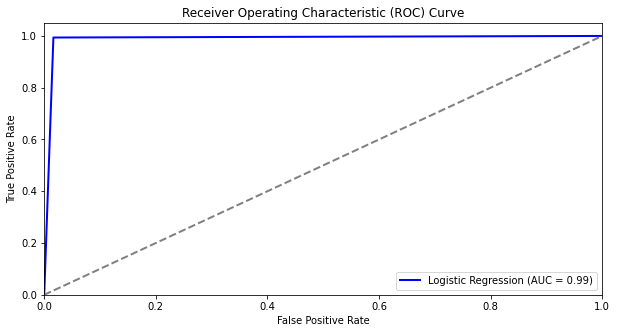

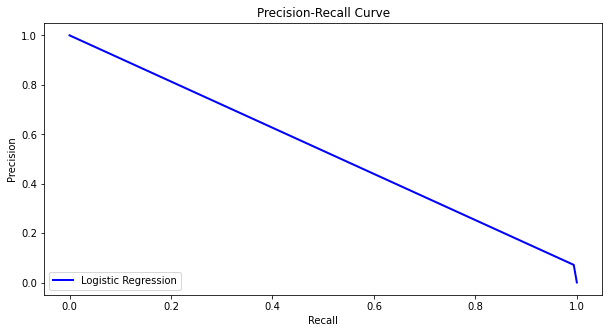

In [13]:
def plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.savefig(f"{VISUALIZATION_DIRECTORY}/{filename}.png", dpi=300, bbox_inches="tight")

    plt.show()


def plot_pr_curve(recall_lr, precision_lr, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(recall_lr, precision_lr, color='blue', lw=2, label='Logistic Regression')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.savefig(f"{VISUALIZATION_DIRECTORY}/{filename}.png", dpi=300, bbox_inches="tight")

    plt.show()

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, 'rf_roc_curve')

# Calculate Precision-Recall curve for Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_rf)

plot_pr_curve(recall_lr, precision_lr, 'rf_precision_recall')

In [10]:
filename = f"{MODELS_TRAINED_DIRECTORY}/best_rf.pkl"
joblib.dump(best_rf, filename)
print("Model saved as best_rf.pkl")

Model saved as best_rf.pkl


In [44]:
X_train_preprocessed_resampled.shape

(10167052, 10)

In [16]:
# Converting to torch tensor

X_train_tensor = torch.tensor(X_train_preprocessed_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
iterator = iter(train_loader)
data = next(iterator)
data[0].shape

torch.Size([64, 10])

### Federated Learning

In this project, we will be dealing with a specialised form of machine learning called *federated learning*. To do this we will simulate a federated learning setup right here in this notebook with aim to achieve best possible solution. It works by having Client objects who will act as our nodes which we will train on locally, and a Server object which acts as our centralised server containing the global model. The aggregation strategy will be fixed here to **FedAvg**.

The equation for **FedAvg** [1] is the following:

 $$w^{t+1} = \dfrac{1}{n}\sum_{k=1}^{K} w_{k}^{t+1}$$

Each term represents:
* $w^{t+1}$: Updated global model parameters after round $t$.
* $n$: Total number of clients.
* $w_{k}^{t+1}$: Updated model parameters from client $k$ after local training.

When sending the model from the Server to the Client we will do a local average instead of overwriting the local model weights (with the global model) to preserve local structure in the local models at the respective Clients (take a look at 'send_with_local_ave' within the Server class).

In [19]:
# Federated Learning Framework
class Client:
    """
    A class representing a client in a federated learning setup.

    Attributes:
    - device: The device on which the client's model and data will be loaded (CPU or CUDA).
    - model: The initial model assigned to the client.
    - data: The dataset assigned to the client.
    - id: A unique identifier for the client.
    """
    def __init__(self, initial_model, data, id):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = initial_model.to(self.device)
        self.data = data
        self.id = id

    def get_model_params(self):
        """
        Returns the state dictionary of the client's model.

        Returns:
        - state_dict: The state dictionary of the client's model.
        """
        return self.model.state_dict()


class Server:
    """
    A class representing a central server in a federated learning setup.

    Attributes:
    - device: The device on which the server's global model will be loaded (CPU or CUDA).
    - global_model: The global model maintained by the server.
    - send_funcs: A dictionary mapping boolean flags to the corresponding send functions.
    - send: The send function to be used (with or without local averaging) mimicking sending of weights from server to client.
    """
    def __init__(self, model, local_weight_ave=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model = model.to(self.device)
        self.send_funcs = {
            True: self.send_with_local_ave,
            False: self.send_without_local_ave
        }
        self.send = self.send_funcs[local_weight_ave]

    def send_without_local_ave(self, client):
        """
        Sends the global model to the client without local averaging.

        Parameters:
        - client: The client to which the global model will be sent.
        """
        client.model.load_state_dict(self.global_model.state_dict())
        print(f"Sent model to Client {client.id}")

    def send_with_local_ave(self, client):
        """
        Sends the global model to the client with local averaging.

        Parameters:
        - client: The client to which the averaged model will be sent.
        """
        global_params = self.global_model.state_dict()
        local_params = client.get_model_params()
        averaged_params = {key: (global_params[key] + local_params[key]) / 2 for key in global_params.keys()}
        client.model.load_state_dict(averaged_params)
        print(f"Sent model to Client {client.id}")

    def train(self, clients, gen_optimizer, loss_fn, num_epochs, batch_size=8, shuffle=True, lr=0.01):
        """
        Trains the global model using data from multiple clients.

        Parameters:
        - clients: A list of Client objects.
        - gen_optimizer: The optimizer generator function (basically a wrapper of a PyTorch optimiser object).
        - loss_fn: The loss function to be used for training.
        - num_epochs: The number of epochs for training.
        - batch_size: The batch size for data loading (default is 8).
        - shuffle: Whether to shuffle the data (default is True).
        - lr: Learning rate for the optimizer (default is 0.01).
        """
        client_weights = []
        for client in clients:
            self.send(client)
            data_loader = DataLoader(client.data, batch_size=batch_size, shuffle=shuffle)
            optimizer = gen_optimizer(params=client.model.parameters(), lr=lr)
            client.model.train()
            print(f'Begin local training at Client {client.id}')
            for epoch in range(num_epochs):
                losses = []
                for data, target in data_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    optimizer.zero_grad()
                    # print(f"loaded data")
                    output = client.model(data)
                    loss = loss_fn(output, target)
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.clone().detach())
                ave_loss = torch.mean(torch.tensor(losses))
                print(f'Training loss, running average over batches, at end of epoch {epoch} is {ave_loss}')
            print(f'End of local training at Client {client.id}')
            client_weights.append(client.get_model_params())
            print('------------------------------------------------------------------')

        avg_model_params = self.aggregate_weights(client_weights)
        self.global_model.load_state_dict(avg_model_params)

    def aggregate_weights(self, client_weights):
        """
        Aggregates the weights from multiple clients using simple averaging.

        Parameters:
        - client_weights: A list of state dictionaries from clients.

        Returns:
        - avg_params: The averaged state dictionary.
        """
        avg_params = {key: torch.zeros_like(param) for key, param in client_weights[0].items()}
        for params in client_weights:
            for key in params.keys():
                avg_params[key] += params[key] / len(client_weights)
        return avg_params

    # need a nice test function here that incorporates all of your "FAIR" metrics
    # def test(self, validation_dataset, batch_size=64, device=None):


def setup_federated_simulation_env(model, client_names, dataset, data_weights, local_weight_ave=True):
    """
    Sets up the federated learning simulation environment.

    Parameters:
    - model: The initial global model.
    - client_names: A list of names for the clients.
    - dataset: The dataset to be split among the clients.
    - data_weights: A list of weights specifying the proportion of data for each client.
    - local_weight_ave: A boolean flag indicating whether to use local weight averaging (default is True).

    Returns:
    - central_server: The Server object.
    - clients: A list of Client objects.
    """
    print('---------- Setting up Federating Learning Environment ----------')
    print('...')
    central_server = Server(model, local_weight_ave=local_weight_ave)
    if len(client_names) != len(data_weights):
        raise ValueError("Number of clients does not match proposed data splitting given data weights.")
    subset_datasets = split_dataset(dataset, data_weights)
    clients = [Client(model, subset_dataset, client_name) for client_name, subset_dataset in zip(client_names, subset_datasets)]
    print('---------- Finished Setting up Federating Learning Environment ----------')
    print()
    return central_server, clients

from torch.utils.data import Subset

def split_dataset(dataset, data_weights):
    """
    Splits a dataset into multiple subsets according to specified weights.

    Parameters:
    - dataset: The original dataset to be split.
    - data_weights: A list of weights specifying the proportion of each subset.
                    The sum of data_weights should be 1.

    Returns:
    - A list of dataset objects, each corresponding to a subset of the original dataset.
    """
    if not np.isclose(np.sum(data_weights), 1):
        raise ValueError('Invalid data_weights, do not sum to 1.')
    total_samples = len(dataset)
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    split_indices = []
    current_idx = 0
    for weight in data_weights:
        split_size = int(np.floor(weight * total_samples))
        split_indices.append(indices[current_idx:current_idx + split_size])
        current_idx += split_size

    # Ensure that all samples are included (add the remaining samples to the last subset)
    if current_idx < total_samples:
        split_indices[-1] = np.concatenate((split_indices[-1], indices[current_idx:]), axis=0)

    # Create the subset datasets
    subset_datasets = [Subset(dataset, indices) for indices in split_indices]

    return subset_datasets

In [20]:
# Define CNN
import torch.nn as nn
import torch.nn.functional as F

# simple MLP
class MLP(nn.Module):
    def __init__(self, input_dim=10*1, hidden_dim=32, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out


In [21]:
# CNN
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = MLP()
global_model = model


client_names = ['Bank 1', 'Bank 2', 'Bank 3', 'Bank 4']
data_weights = [0.25, 0.25, 0.25, 0.25]
server, clients =  setup_federated_simulation_env(model = global_model, client_names = client_names, dataset = train_dataset, data_weights = data_weights, local_weight_ave = True)

# Define optimizer and loss function
def gen_optimizer(params, lr):
    return torch.optim.SGD(params=params, lr=lr)

def criterion(input, target):
    loss_fn = torch.nn.CrossEntropyLoss()
    return loss_fn(input, target)

# Train using Federated Averaging
server.train(clients, gen_optimizer, loss_fn = criterion, num_epochs=5, lr = 0.001)

---------- Setting up Federating Learning Environment ----------
...
---------- Finished Setting up Federating Learning Environment ----------

Sent model to Client Bank 1
Begin local training at Client Bank 1
Training loss, running average over batches, at end of epoch 0 is 0.2210703045129776
Training loss, running average over batches, at end of epoch 1 is 0.13019713759422302
Training loss, running average over batches, at end of epoch 2 is 0.10931964963674545
Training loss, running average over batches, at end of epoch 3 is 0.09926050901412964
Training loss, running average over batches, at end of epoch 4 is 0.09231982380151749
End of local training at Client Bank 1
------------------------------------------------------------------
Sent model to Client Bank 2
Begin local training at Client Bank 2
Training loss, running average over batches, at end of epoch 0 is 0.08861880004405975
Training loss, running average over batches, at end of epoch 1 is 0.08537393063306808
Training loss, ru

In [23]:
def get_accuracy(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes overall accuracy for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 128).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - overall_accuracy: The overall accuracy over the entire dataset.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    # Compute overall accuracy
    overall_accuracy = (all_outputs.argmax(dim=1) == all_targets).float().mean().item()

    return overall_accuracy

def get_confusion_matrix(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes and displays the confusion matrix for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 64).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - cm: Confusion matrix
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Predicting Disease')
    plt.savefig(f"{VISUALIZATION_DIRECTORY}/nn_cm_federated_learning.png", dpi=300, bbox_inches="tight")
    plt.show()

    return cm

def get_sensitivity(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the sensitivity metric for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - sensitivity: The sensitivity metric.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    return sensitivity

def get_specificity(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the specificity metric for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - specificity: The specificity metric.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return specificity


In [24]:
get_accuracy(clients[0].data, clients[0].model)

0.9780738949775696

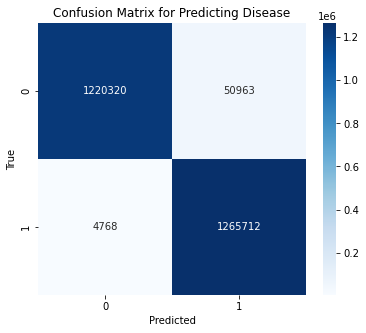

array([[1220320,   50963],
       [   4768, 1265712]])

In [25]:
get_confusion_matrix(clients[0].data, clients[0].model)

In [26]:
specificity = get_specificity(clients[0].data, clients[0].model)
sensitivity = get_sensitivity(clients[0].data, clients[0].model)

print(f'The specificity for {clients[0].id} is {specificity}')
print(f'The sensitivity for {clients[0].id} is {sensitivity}')

The specificity for Bank 1 is 0.9599121517396205
The sensitivity for Bank 1 is 0.9962470877148795


In [27]:
def get_balanced_accuracy(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the balanced accuracy for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - balanced_accuracy: The average balanced accuracy over all classes.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_acc = (sensitivity + specificity) / 2


    # balanced_accuracy = sum(class_balanced_accuracies) / num_classes
    return balanced_acc

# NB change the doc string here because you are no longer doing multi-class
def get_auroc_plot_roc(validation_dataset, model, batch_size=128, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Calculate the AUROC and plot the ROC curve for a binary classification problem.

    Parameters:
    validation_dataset (Dataset): The validation dataset.
    model (nn.Module): The trained model.
    batch_size (int): The batch size for data loading.
    device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
    roc_auc: AUROC value.
    """
    # Set the model to evaluation mode
    model.eval()

    # Create a DataLoader for the validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store true labels and predicted probabilities
    all_labels = []
    all_probs = []

    # Disable gradient calculation for validation
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to the specified device
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits)
            logits = model(inputs)

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=1)

            # Store labels and probabilities
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())

    # Concatenate all batches
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    all_probs = all_probs[:,1] # you need to only look at a single class for this metric


    # Calculate ROC curve and AUROC

    plt.figure(figsize=(12, 8))
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f' ROC model predictor (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label = 'ROC random predictor (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(f"{VISUALIZATION_DIRECTORY}/nn_roc_federated_learning.png", dpi=300, bbox_inches="tight")
    plt.show()
    return roc_auc

In [28]:
get_balanced_accuracy(clients[0].data, clients[0].model)

0.97807961972725

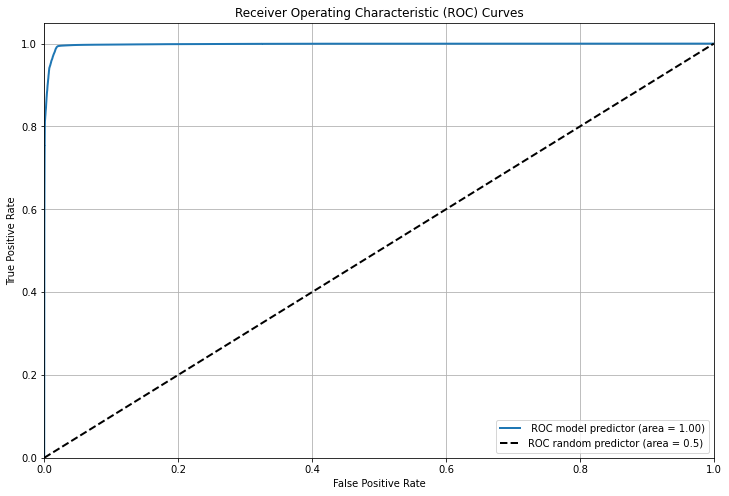

0.9978658252866482

In [29]:
get_auroc_plot_roc(clients[0].data, clients[0].model)

In [30]:
global_model = server.global_model

filename = f"{MODELS_TRAINED_DIRECTORY}/cnn_global_model.pkl"
joblib.dump(global_model, filename)
print("Model saved as global_model.pkl")

Model saved as global_model.pkl


In [34]:
# KANs - Komgorov Arnolds Networks
!pip install pykan

     |████████████████████████████████| 78 kB 1.0 MB/s            


In [35]:
from kan import *

In [41]:
!nvidia-smi

Tue Nov 26 10:59:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 24%   34C    P8    11W / 250W |   7606MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 22%   

In [56]:
device = torch.device("cuda:2")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_inputs = torch.empty(0, 10, device=device)
train_labels = torch.empty(0, dtype=torch.long, device=device)
test_inputs = torch.empty(0, 10, device=device)
test_labels = torch.empty(0, dtype=torch.long, device=device)

# Concatenate all data into a single tensor on the specified device
for data, labels in train_loader:
    train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
    train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

for data, labels in test_loader:
    test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
    test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

dataset = {}
dataset['train_input'] = train_inputs
dataset['test_input'] = test_inputs
dataset['train_label'] = train_labels
dataset['test_label'] = test_labels

KeyboardInterrupt: 

In [42]:
image_folder = 'video_img'

model = KAN(width=[10, 5, 2], grid=5, k=3, seed=42, device=device)

model(dataset['train_input']) # in_vars are features, out_vars are Yes No
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['No', 'Yes'])

checkpoint directory created: ./model
saving model version 0.0


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.79 GiB (GPU 3; 10.76 GiB total capacity; 6.48 GiB already allocated; 3.46 GiB free; 6.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

checkpoint directory created: ./model
saving model version 0.0
Epoch [1/1], Step [100/158861], Loss: 0.6036
Epoch [1/1], Step [200/158861], Loss: 0.4061
Epoch [1/1], Step [300/158861], Loss: 0.3124
Epoch [1/1], Step [400/158861], Loss: 0.2980
Epoch [1/1], Step [500/158861], Loss: 0.1632
Epoch [1/1], Step [600/158861], Loss: 0.2504
Epoch [1/1], Step [700/158861], Loss: 0.1662
Epoch [1/1], Step [800/158861], Loss: 0.2165
Epoch [1/1], Step [900/158861], Loss: 0.1792
Epoch [1/1], Step [1000/158861], Loss: 0.1669
Epoch [1/1], Step [1100/158861], Loss: 0.1489
Epoch [1/1], Step [1200/158861], Loss: 0.1292
Epoch [1/1], Step [1300/158861], Loss: 0.1255
Epoch [1/1], Step [1400/158861], Loss: 0.0926
Epoch [1/1], Step [1500/158861], Loss: 0.2455
Epoch [1/1], Step [1600/158861], Loss: 0.1312
Epoch [1/1], Step [1700/158861], Loss: 0.0813
Epoch [1/1], Step [1800/158861], Loss: 0.0909
Epoch [1/1], Step [1900/158861], Loss: 0.1040
Epoch [1/1], Step [2000/158861], Loss: 0.0659
Epoch [1/1], Step [2100/15

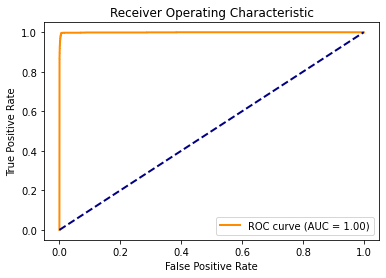

AUC: 1.00


In [49]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import time

device = torch.device("cuda:2")
model = KAN(width=[10, 5, 2], grid=5, k=3, seed=42, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Choose an optimizer
criterion = torch.nn.CrossEntropyLoss()  # Replace with your desired loss function

# Training loop
def train_model(model, train_loader, device, optimizer, criterion, num_epochs=10):
    model.to(device)  # Ensure the model is on the correct device
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()
        for i, (data, labels) in enumerate(train_loader):
            # Move mini-batch to device
            data, labels = data.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print progress for every 100 batches
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}")
        print(f"Epoch running time: {(time.time() - start_time)!r}")

# Train the model in mini-batches
train_model(model, train_loader, device, optimizer, criterion, num_epochs=1)

def evaluate_model_with_roc(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            # Get predicted probabilities (softmax outputs for classification)
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            
            all_probs.extend(probabilities.cpu().numpy())  # Collect probabilities
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    # plt.figure()
    # plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Receiver Operating Characteristic")
    # plt.legend(loc="lower right")
    # plt.savefig(f"{VISUALIZATION_DIRECTORY}/kan_train.png", dpi=300, bbox_inches="tight")
    # plt.show()

    print(f"AUC: {roc_auc:.2f}")

# Call the function
evaluate_model_with_roc(model, test_loader, device)

AUC: 0.9992017961605131
Precision: 0.12326911499096929
Recall: 0.996956786366403
Confusion Matrix:
[[1259231   11650]
 [      5    1638]]
Classification Report:
{'Class 0': {'precision': 0.9999960293384242, 'recall': 0.9908331307179823, 'f1-score': 0.9953934936605698, 'support': 1270881}, 'Class 1': {'precision': 0.12326911499096929, 'recall': 0.996956786366403, 'f1-score': 0.21940928270042193, 'support': 1643}, 'accuracy': 0.9908410371827958, 'macro avg': {'precision': 0.5616325721646968, 'recall': 0.9938949585421926, 'f1-score': 0.6074013881804958, 'support': 1272524}, 'weighted avg': {'precision': 0.9988640567231549, 'recall': 0.9908410371827958, 'f1-score': 0.9943915934538882, 'support': 1272524}}
Classification report saved as 'report.csv'


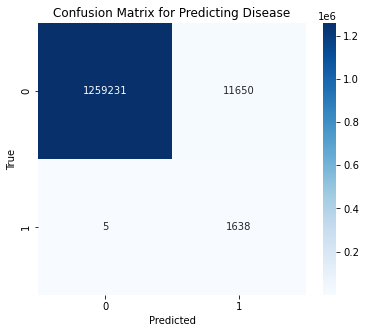

In [95]:

def evaluate_model_with_roc(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            # Get model outputs
            outputs = model(data)
            
            # Predicted probabilities for the positive class
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            # Predicted class labels (0 or 1)
            predictions = torch.argmax(outputs, dim=1)
            
            all_probs.extend(probabilities.cpu().numpy())  # Collect probabilities
            all_preds.extend(predictions.cpu().numpy())   # Collect predictions
            all_labels.extend(labels.cpu().numpy())       # Collect true labels

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc}")

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"], output_dict=True)
    print("Classification Report:")
    print(report)

    import matplotlib.pyplot as plt
    # report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
    report = pd.DataFrame(report).transpose()
    report.style.background_gradient(cmap='Blues')

    report.to_csv(f"{STATISTICS_DIRECTORY}/kans_fed_learn.csv", index=True)
    print("Classification report saved as 'report.csv'")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Predicting Disease')
    plt.savefig(f"{VISUALIZATION_DIRECTORY}/cm_kans_fed.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.figure()
    # plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Receiver Operating Characteristic")
    # plt.legend(loc="lower right")
    # plt.savefig(f"roc_curve.png", dpi=300, bbox_inches="tight")
    # plt.show()

evaluate_model_with_roc(model, test_loader, device)

In [52]:
!pip install dill

In [54]:
import dill

filename = f"{MODELS_TRAINED_DIRECTORY}/kan_no_fed.pkl"
# joblib.dump(model, filename)
with open(filename, "wb") as f:
    dill.dump(model, f)
print("Model saved as global_model.pkl")

Model saved as global_model.pkl


In [62]:
device = torch.device('cuda:3')
device

device(type='cuda', index=3)

In [69]:
model.plot(scale=1, in_vars=[f'Feature{i!r}' for i in range(10)], out_vars=['No', 'Yes'])

IndexError: list index out of range

In [75]:
!pip install --upgrade imageio

     |████████████████████████████████| 315 kB 1.4 MB/s            
  Attempting uninstall: imageio
    Found existing installation: imageio 2.13.5
    Uninstalling imageio-2.13.5:
      Successfully uninstalled imageio-2.13.5


In [77]:
# import moviepy.video.io.ImageSequenceClip

# video_name='video'
# fps=10

# fps = fps
# files = os.listdir(image_folder)
# train_index = []
# for file in files:
#     if file[0].isdigit() and file.endswith('.jpg'):
#         train_index.append(int(file[:-4]))

# train_index = np.sort(train_index)

# image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile(video_name+'.mp4')

In [79]:
# model = model.prune()
# model(dataset['train_input'])
# model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['No', 'Yes'])


In [ ]:
# # fine tune
# results_1 = model.fit(dataset, opt="Adam", metrics=(train_acc, test_acc),
#                       loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10.)
# results_1['train_acc'][-1], results_1['test_acc'][-1]

In [ ]:
# model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['No', 'Yes'])

In [88]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# model.auto_symbolic(lib=lib)

In [85]:
# formula1, formula2, formula3 = model.symbolic_formula()[0]

In [83]:
model.symbolic_formula()

([0, 0], [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10])

In [ ]:
# Comparing to other models
y_true = df['isFraud']  # Ground truth
y_pred_paysim = df['isFlaggedFraud']  # PaySim model predictions

precision_paysim = precision_score(y_true, y_pred_paysim)
recall_paysim = recall_score(y_true, y_pred_paysim)
report = classification_report(y_true, y_pred_paysim, output_dict=True)
report = pd.DataFrame(report).transpose()
report.style.background_gradient(cmap='Blues')

report.to_csv(f"{STATISTICS_DIRECTORY}/paysim_true_labels.csv", index=True)
print(report)

auc_roc_paysim = roc_auc_score(y_true, y_pred_paysim)

conf_matrix_paysim = confusion_matrix(y_true, y_pred_paysim)

print("PaySim Model Metrics:")
print(f"Precision: {precision_paysim}")
print(f"Recall: {recall_paysim}")
print(f"AUC-ROC: {auc_roc_paysim}")
print(f"Confusion Matrix:\n{conf_matrix_paysim}")

              precision    recall  f1-score       support
0              0.998712  1.000000  0.999355  6.354407e+06
1              1.000000  0.001948  0.003889  8.213000e+03
accuracy       0.998712  0.998712  0.998712  9.987117e-01
macro avg      0.999356  0.500974  0.501622  6.362620e+06
weighted avg   0.998713  0.998712  0.998070  6.362620e+06
PaySim Model Metrics:
Precision: 1.0
Recall: 0.0019481310118105442
AUC-ROC: 0.5009740655059053
Confusion Matrix:
[[6354407       0]
 [   8197      16]]
